In [3]:
import os         # OS operations
import kagglehub  # Library to download datasets from Kaggle

# Create a directory for the dataset if it doesn't exist
os.makedirs("./data/xray", exist_ok=True)
# Download the dataset from Kaggle using kagglehub
path = kagglehub.dataset_download("orvile/x-ray-baggage-anomaly-detection")

print("Path to dataset files:", path)  # Print the path where the dataset was downloaded

Path to dataset files: /Users/sebastiancarreras/.cache/kagglehub/datasets/orvile/x-ray-baggage-anomaly-detection/versions/1


Data analysis is in process...

Data analysis is in process...

Data analysis is in process...



/var/folders/sp/hjjl899x4js87jvp7rfdpj2w0000gn/T/ipykernel_26370/1910355420.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names, rotation = 90)
/var/folders/sp/hjjl899x4js87jvp7rfdpj2w0000gn/T/ipykernel_26370/1910355420.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names, rotation = 90)
/var/folders/sp/hjjl899x4js87jvp7rfdpj2w0000gn/T/ipykernel_26370/1910355420.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names, rotation = 90)


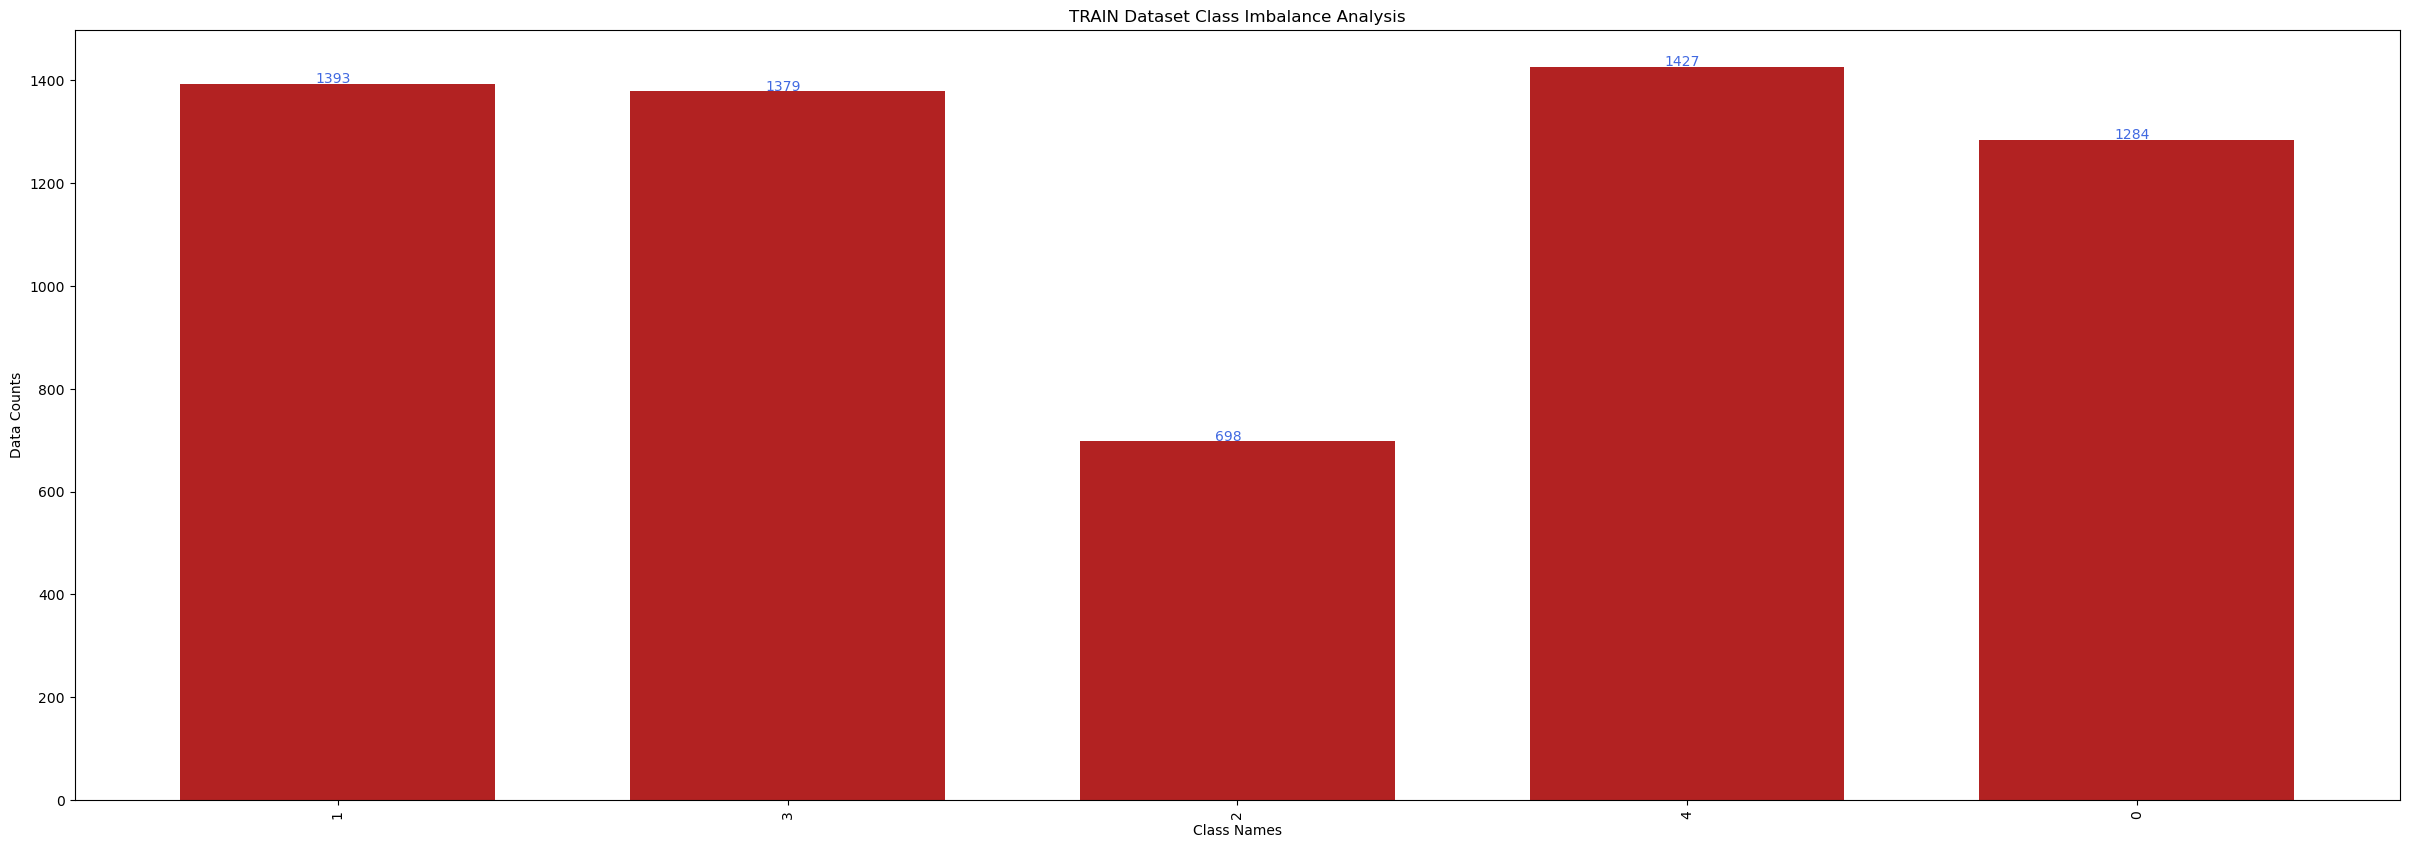

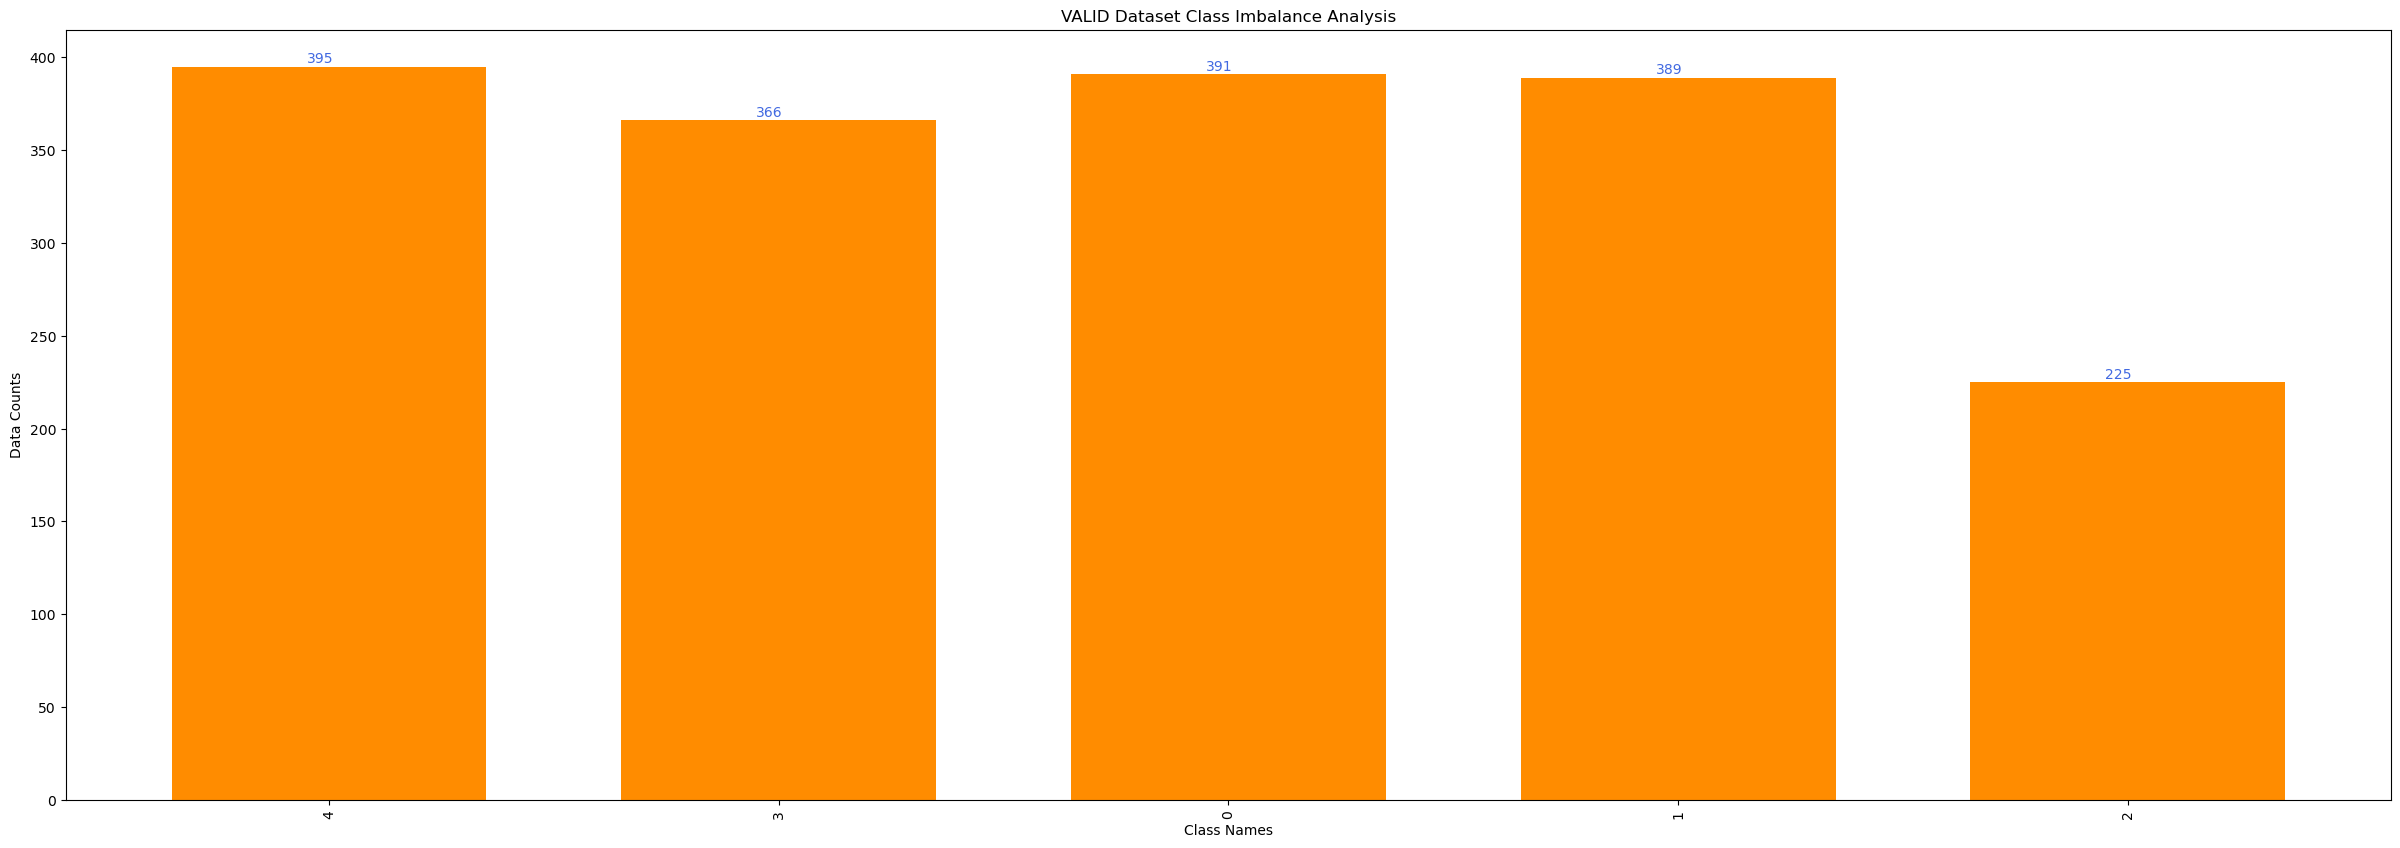

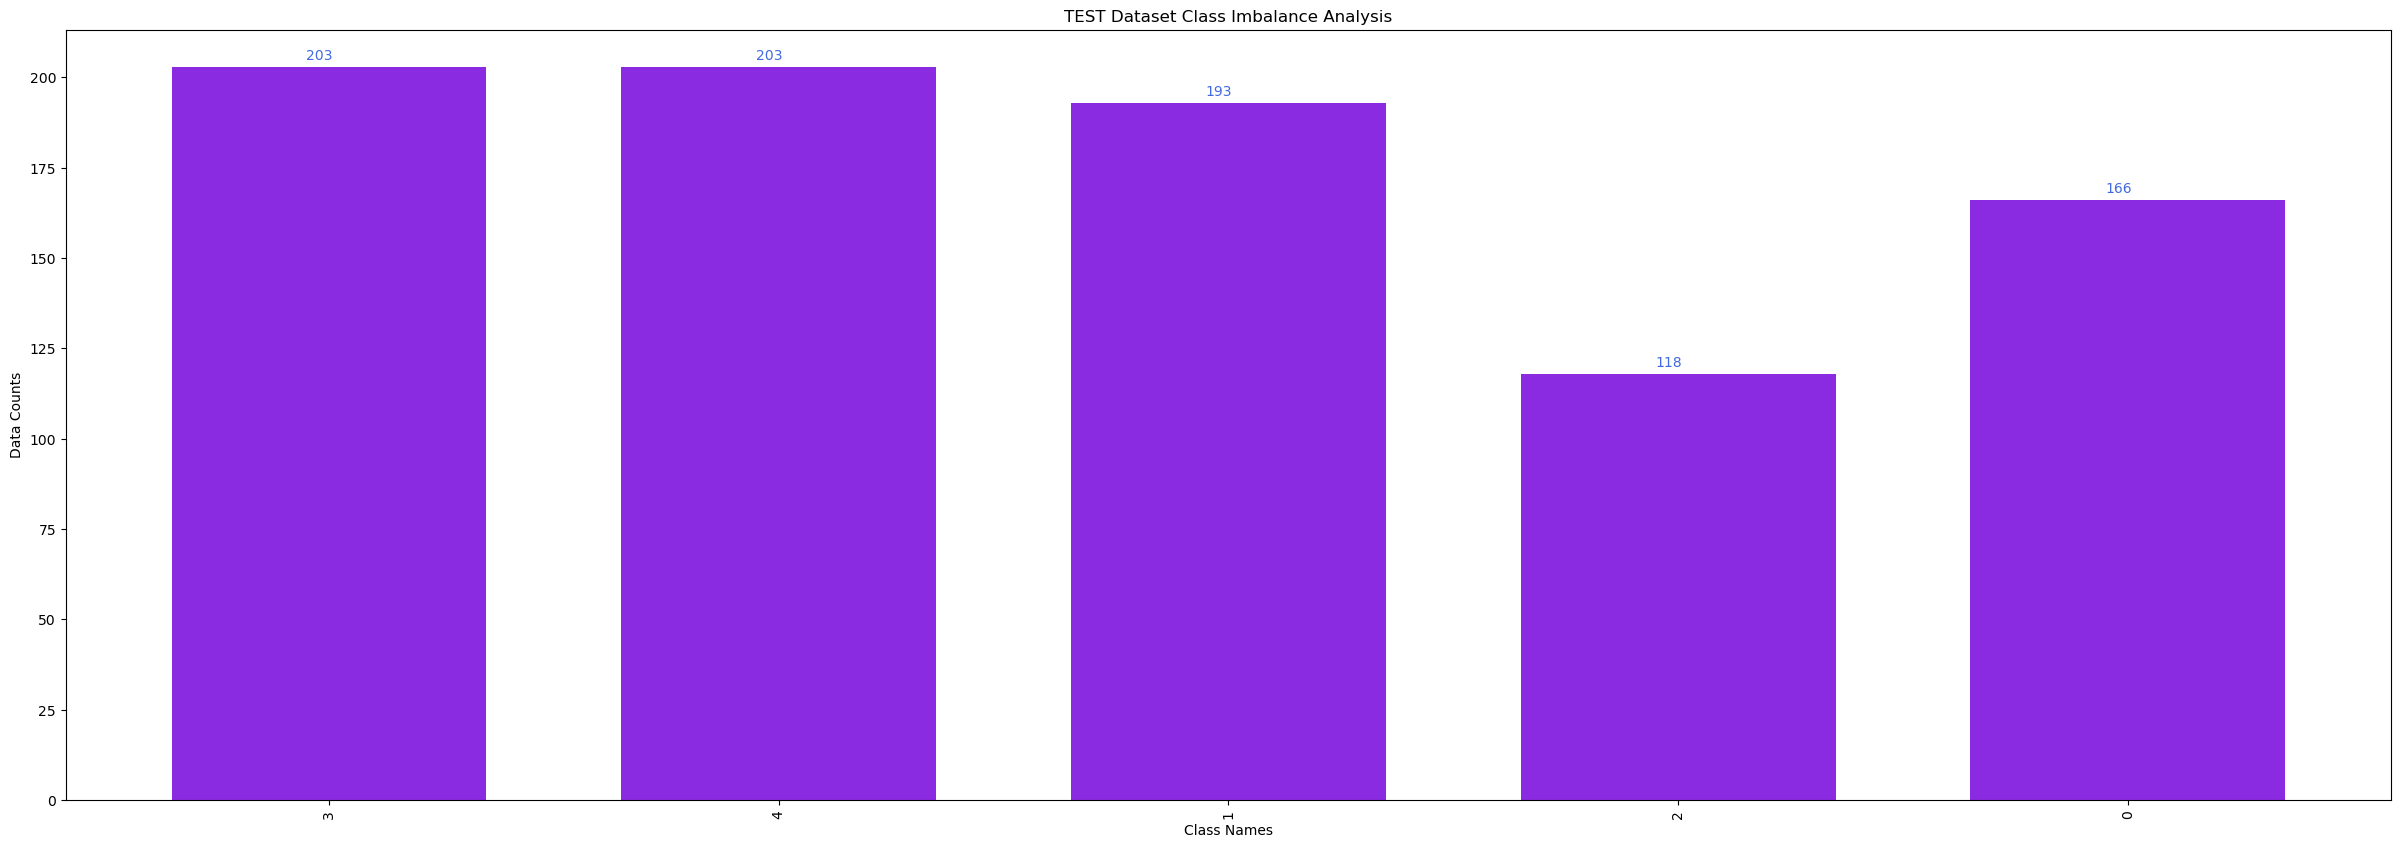

In [ ]:
import os, cv2, yaml, random, numpy as np
from PIL import Image
from glob import glob
from matplotlib import pyplot as plt
from torchvision import transforms as T

class Visualization:

    def __init__(self, root, data_types, n_ims, rows, cmap = None):

        self.n_ims, self.rows = n_ims, rows
        self.cmap, self.data_types  = cmap, data_types
        self.colors = ["firebrick", "darkorange", "blueviolet"]
        
        self.get_cls_names(); self.get_bboxes()        
                
    def get_cls_names(self):

        with open(f"{root}/data.yaml", 'r') as file: data = yaml.safe_load(file)      
        # Extract class names
        class_names = data['names']        
        
        # Create a dictionary with index as key and class name as value
        self.class_dict = {index: name for index, name in enumerate(class_names)}        
    
    def get_bboxes(self):

        self.vis_datas, self.analysis_datas, self.im_paths = {}, {}, {}
        for data_type in self.data_types:
            all_bboxes, all_analysis_datas = [], {}
            im_paths = glob(f"{root}/{data_type}/images/*") #guarda el path a todos los archivos en la carpeta train ,test, y valid
            
            for idx, im_path in enumerate(im_paths):
                # if idx == 3: break                
                bboxes = []
                im_ext = os.path.splitext(im_path)[-1]
                lbl_path = im_path.replace(im_ext, ".txt")
                lbl_path  = lbl_path.replace(f"{data_type}/images", f"{data_type}/labels")
                if not os.path.isfile(lbl_path): continue                
                meta_data = open(lbl_path).readlines()
                for data in meta_data:                    
                    # Split the string by space and strip the newline character
                    # Change here 
                    parts = data.strip().split()[:5]
                    cls_name = self.class_dict[int(parts[0])]
                    # Convert first element to integer and the rest to float
                    bboxes.append([cls_name] + [float(x) for x in parts[1:]])
                    if cls_name not in all_analysis_datas: all_analysis_datas[cls_name] = 1
                    else: all_analysis_datas[cls_name] += 1
                all_bboxes.append(bboxes)
                    
            self.vis_datas[data_type] = all_bboxes; self.analysis_datas[data_type] = all_analysis_datas; self.im_paths[data_type] = im_paths
    
    def plot(self, rows, cols, count, im_path, bboxes):
    
        plt.subplot(rows, cols, count)
        or_im = np.array(Image.open(im_path).convert("RGB"))
        height, width, _ = or_im.shape

        for bbox in bboxes:
            
            class_id, x_center, y_center, w, h = bbox

            # Convert YOLO format to pixel values
            x_min = int((x_center - w / 2) * width)  # x_min
            y_min = int((y_center - h / 2) * height)  # y_min
            x_max = int((x_center + w / 2) * width)  # x_max
            y_max = int((y_center + h / 2) * height)  # y_max
            
            color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            cv2.rectangle(img = or_im, pt1 = (x_min, y_min), pt2 = (x_max, y_max), color = color, thickness = 3)
        plt.imshow(or_im)
        plt.axis("off"); 
        plt.title(f"There is (are) {len(bboxes)} object(s) in the image.")
        
        return count + 1

    def vis(self, save_name):

        print(f"{save_name.upper()} Data Visualization is in process...\n")
        assert self.cmap in ["rgb", "gray"], "Please choose rgb or gray cmap"
        if self.cmap == "rgb": cmap = "viridis"
        cols = self.n_ims // self.rows; count = 1
        
        plt.figure(figsize = (25, 20))
                
        indices = [random.randint(a = 0, b = len(self.vis_datas[save_name]) - 1) for _ in range(self.n_ims)]

        for idx, index in enumerate(indices):
        
            if count == self.n_ims + 1: break
            
            im_path, bboxes = self.im_paths[save_name][index], self.vis_datas[save_name][index]

            count = self.plot(self.rows, cols, count, im_path = im_path, bboxes = bboxes)
            
        plt.show()

    def data_analysis(self, save_name, color):

        print("Data analysis is in process...\n")
        
        width, text_width, text_height = 0.7, 0.05, 2
        cls_names = list(self.analysis_datas[save_name].keys()); counts = list(self.analysis_datas[save_name].values())
        
        _, ax = plt.subplots(figsize = (30, 10))
        indices = np.arange(len(counts))

        ax.bar(indices, counts, width, color = color)
        ax.set_xlabel("Class Names", color = "black")
        ax.set_xticklabels(cls_names, rotation = 90)
        ax.set(xticks = indices, xticklabels = cls_names)
        ax.set_ylabel("Data Counts", color = "black")
        ax.set_title(f"{save_name.upper()} Dataset Class Imbalance Analysis")

        for i, v in enumerate(counts): ax.text(i - text_width, v + text_height, str(v), color = "royalblue")
    
    def visualization(self): [self.vis(save_name) for save_name in self.data_types]
        
    def analysis(self): [self.data_analysis(save_name, color) for (save_name, color) in zip(self.data_types, self.colors)]
        
root =path #"/kaggle/input/x-ray-baggage-anomaly-detection"
vis = Visualization(root = root, data_types = ["train", "valid", "test"], n_ims = 20, rows = 5, cmap = "rgb")
vis.analysis()